# Classification Models Comparisons

in this notebook we will use different kinds of Image classification models and compare them on the given categories. 
The first one will be looking at is accuracy and Loss because they're our prioties during this training and also the time it takes to predict the image. 

1. Setup
2. Data preparation (data spliting and labeling), and Exploration
3. Building Model
    - Residual Network https://paperswithcode.com/method/resnet  
    https://tfhub.dev/google/supcon/resnet_v1_200/imagenet/classification/1
    
    - VGG-16 https://paperswithcode.com/method/vgg-16  
    https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

    - Alex Net https://paperswithcode.com/method/alexnet   
    https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8

    - Dense Net https://paperswithcode.com/method/densenet  
    https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet
    
4. Ensemble Approaches 
https://www.tensorflow.org/tutorials/images/classification
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

5. Comparisons
6. Results

## 1. Setup
This Python 3 environment comes with many helpful analytics libraries installed  
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python  
For example, here's several helpful packages to load.   
In this stage we will use this data set https://paperswithcode.com/dataset/tiny-imagenet. 
 
Enable Cuda For fast training 

In [2]:
# Remved warnings 
import warnings  
warnings.filterwarnings('ignore')

# This packages are used for file handling
import os
import os.path
import random 
import pickle 
from tqdm import tqdm
from datetime import datetime

# Used for plotting and visualizations
%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt 

# For linear algebra and arrays manipulation 
import cv2 
import math
import random 
import pandas as pd
import numpy as np
from numpy import save, load, asarray


# Building machine learning model 
import keras
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import losses
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import mobilenet_v2, mobilenet, densenet
from tensorflow.keras.layers import (Dense, MaxPooling2D, Conv2D, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, 
    DepthwiseConv2D, Dropout, ReLU, Concatenate, DepthwiseConv2D, Input, add,  Conv2DTranspose)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Config variables
from config import * 

In [3]:
# Initialize CUDA
config = ConfigProto()

config.gpu_options.per_process_gpu_memory_fraction = 2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
# Initialize WANDB dashboard 
import wandb
from wandb.keras import WandbCallback

os.environ["WANDB_NOTEBOOK_NAME"] = "main.ipynb"
os.environ["WANDB_API_KEY"] = '2257bf21347391d8f93c8f9f7d620cbbfbf9dcc5'
wandb.login()
wandb.init(project="ResNet50-Nihogalog", entity="coder-ph")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find main.ipynb.
wandb: Currently logged in as: coder-ph (use `wandb login --relogin` to force relogin)


In [5]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='constant'
)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    'data/training',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)

Found 30401 images belonging to 9 classes.


In [7]:
validation_dataget = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    'data/testing',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)

Found 14857 images belonging to 9 classes.


In [8]:
# Initalize Callbacks 
#ModelCheckpoint callback saves a model at some interval. 
filepath="saved_models/weights-improvement-{epoch:02d}-{val_acc:.2f}.ckpt" #File name includes epoch and validation accuracy.

	#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=11, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('nihogalog_logs.csv', separator=',', append=False)

callbacks = [
    # checkpoint, 
    early_stop, 
    log_csv,
    WandbCallback(dataset_name="Resnet")
]

In [9]:
EPOCHS=0.001
LEARNING_RATE = 0.001
DECAY_RATE = LEARNING_RATE/EPOCHS
MOMENTUM =  0.8	

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.2)(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(0.2)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.2)(x)
    return x

    
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.2)(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = Dropout(0.2)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet50(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = Dropout(0.2)(x)

    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    x = Dropout(0.2)(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = Dropout(0.2)(x)

    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

    
model = ResNet50(shape=INPUT_SHAPE, classes=len(CATEGORIES))
sgd = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'])
# model.summary()

history = model.fit( train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/100
951/951 [==============================] - 153s 136ms/step - loss: 1.8296 - accuracy: 0.2934 - val_loss: 1.6017 - val_accuracy: 0.4063 - _timestamp: 1649056086.0000 - _runtime: 174.0000
Epoch 2/100
951/951 [==============================] - 115s 119ms/step - loss: 1.2705 - accuracy: 0.4785 - val_loss: 1.3250 - val_accuracy: 0.4734 - _timestamp: 1649056213.0000 - _runtime: 301.0000
Epoch 3/100
951/951 [==============================] - 117s 122ms/step - loss: 1.1544 - accuracy: 0.5161 - val_loss: 1.1689 - val_accuracy: 0.5113 - _timestamp: 1649056342.0000 - _runtime: 430.0000
Epoch 4/100
951/951 [==============================] - 114s 119ms/step - loss: 1.0994 - accuracy: 0.5488 - val_loss: 1.0820 - val_accuracy: 0.5315 - _timestamp: 1649056469.0000 - _runtime: 557.0000
Epoch 5/100
951/951 [==============================] - 116s 121ms/step - loss: 1.0599 - accuracy: 0.5788 - val_loss: 1.2118 - val_accuracy: 0.5194 - _timestamp: 1649056598.0000 - _runtime: 686.0000
Epoch 6/10

In [11]:
model.save('save-models/resnet50')

INFO:tensorflow:Assets written to: save-models/resnet50\assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', '_timestamp', '_runtime'])

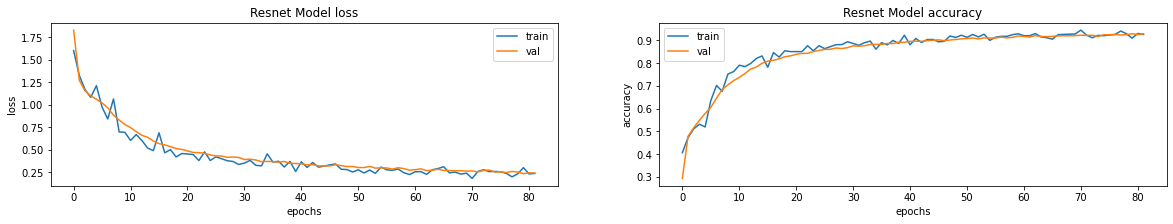

In [12]:

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history['val_'+met])
    ax[i].plot(history.history[met])
    ax[i].set_title('Resnet Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

history.history.keys()

In [13]:

# X, y = [],[]
# for i in range(500):
#     X_gen,y_gen = validation_generator.next()
#     for img, label in zip(X_gen, y_gen):
#         X.append(img)
#         y.append(label)
# X = np.array(X)
# y = np.array(y)
# X.shape, y.shape
model = tf.keras.models.load_model('save-models/resnet50')
X, y = [],[]
total_images = validation_generator.n  
steps = total_images//32
for i in range(steps):
    X_gen,y_gen = validation_generator.next()
    X.extend(X_gen)
    y.extend(y_gen )
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((14848, 50, 50, 3), (14848, 9))

(14848, 50, 50, 3)
465/465 [==============================] - 40s 30ms/step - loss: 0.2328 - accuracy: 0.9256
loss: 0.2327660471200943
acc: 0.9256243109703064


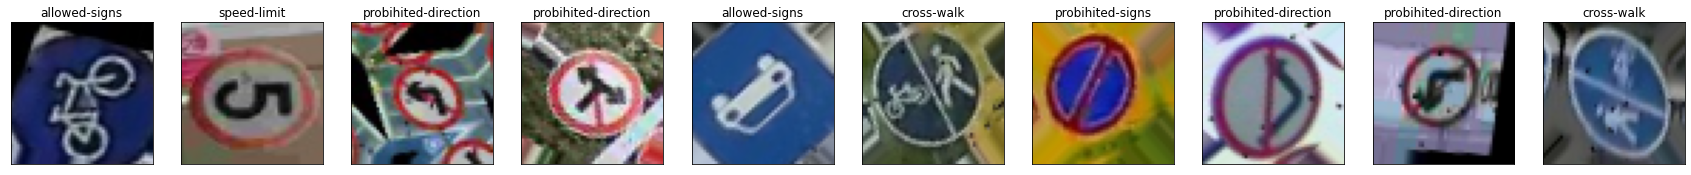

In [14]:

a = X[:10]
preds = model.predict(X[:10])
true_label = np.array([np.argmax(i) for i in preds])

print(X.shape)
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(30,4))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(a[i])
    plt.title(f'{CATEGORIES[true_label[i]]}')
    plt.xticks([])
    plt.yticks([])
eval = model.evaluate(validation_generator)
print(f'loss: {eval[0]}')
print(f'acc: {eval[1]}')


[[1565   39    2    1    0    1    0    3    0]
 [   7 1750    5    0    0    1    0    4    0]
 [  94   71 1334    4    2    8    3   16  106]
 [   1    8    1 1882    4   37    0    6   14]
 [   4    6    1   94 1619   27    0    2    3]
 [   5   11    7   22    0 1507    4   50   17]
 [   0    6   11   16    0   25 1425   43    6]
 [  27    0   43   17    0    8   13 1076  123]
 [   3    1   55    5    0    2    0   15 1580]]


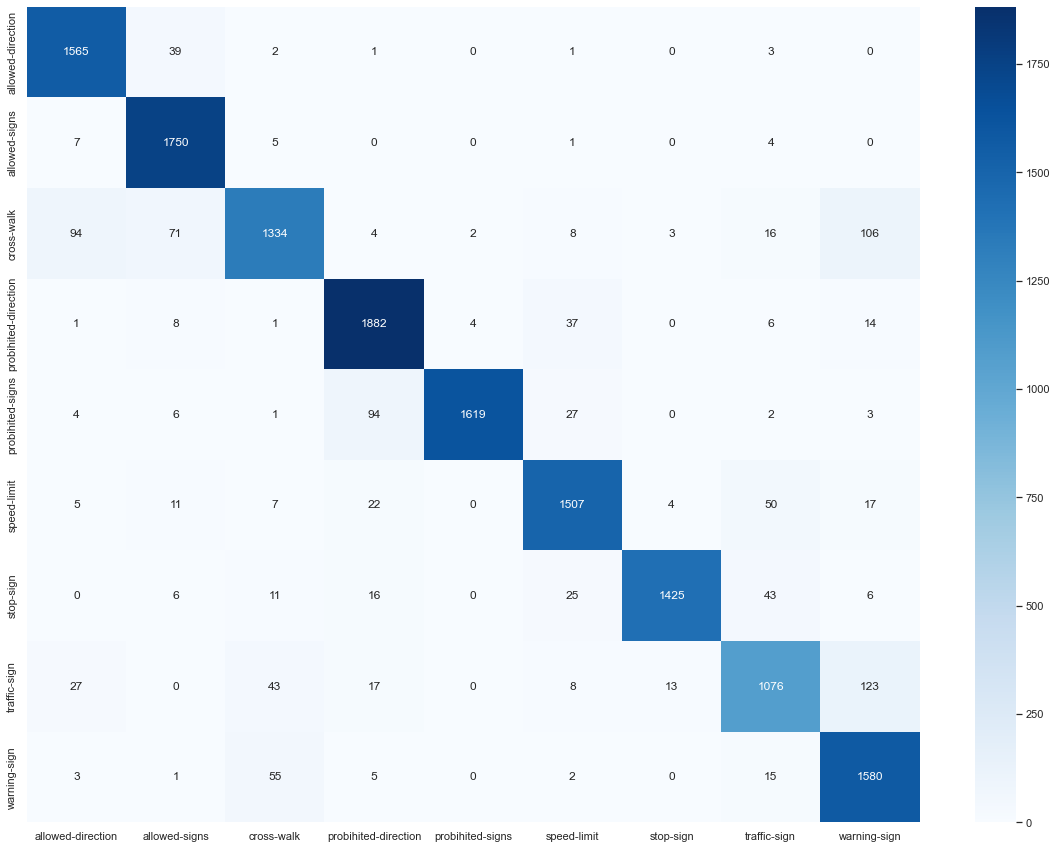

In [16]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns


actual_y = [ np.argmax(i) for i in y]
preds_y =  [ np.argmax(i) for i in model.predict(X)] 
conf_mat = confusion_matrix(actual_y , preds_y)

# sns.set( font_scale=1.5)
plt.figure(figsize=(20,15))
df_cm = pd.DataFrame(conf_mat, CATEGORIES,  CATEGORIES)
sns.set(font_scale=1) # for label size
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax = sns.heatmap(df_cm , annot=True, cmap='Blues', fmt='g')
print(conf_mat)


In [17]:
from sklearn.metrics import classification_report
print(classification_report(actual_y , preds_y, target_names=CATEGORIES))

                      precision    recall  f1-score   support

   allowed-direction       0.92      0.97      0.94      1611
       allowed-signs       0.92      0.99      0.96      1767
          cross-walk       0.91      0.81      0.86      1638
probihited-direction       0.92      0.96      0.94      1953
    probihited-signs       1.00      0.92      0.96      1756
         speed-limit       0.93      0.93      0.93      1623
           stop-sign       0.99      0.93      0.96      1532
        traffic-sign       0.89      0.82      0.85      1307
        warning-sign       0.85      0.95      0.90      1661

            accuracy                           0.93     14848
           macro avg       0.93      0.92      0.92     14848
        weighted avg       0.93      0.93      0.92     14848



In [13]:
# tf.keras.utils.plot_model(
#     model,
#     to_file='model.png',
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False
# )